# The Rising Tide of Life Expectancies

A global health and wealth data exploration inspired by Hans Rosling's TED Talk: [The Best Stats You've Ever Seen](https://youtu.be/hVimVzgtD6w?si=TZL64gkgAxlJ1fqi)

## Load Libraries + Data

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

import os
import random


In [2]:
def read_cleaned_data(path) -> pd.DataFrame:
    result = pd.read_csv(path, index_col = 'country')
    # Pandas automatically uses strings for column names, but we want integer years instead
    result.columns = result.columns.astype(int)
    return result

life_expectancy = read_cleaned_data('../data/life_expectancy_cleaned.csv')
population = read_cleaned_data('../data/population_cleaned.csv')
gni = read_cleaned_data('../data/gni_per_capita_cleaned.csv')

gni_title = "Per Capita GNI (Gross National Income)"
life_expectancy_title = "Life Expectancy"
population_title = "Population"

datasets = {
    gni_title: gni,
    life_expectancy_title: life_expectancy,
    population_title: population
}

print('successfully loaded cleaned datasets.')

successfully loaded cleaned datasets.


In [3]:
# Setup for exporting charts
if not os.path.exists('../charts'):
    os.mkdir('../charts')

## Style Setup

Configure common styles used throughout our data visualizations

In [4]:
def show_default_styles(categories = {'axes', 'figure', 'font'}):
    params = plt.rcParams
    if categories:
        params = { key:value for key, value in params.items() if key.split('.')[0] in categories }
    return params

# customizations:

def customize_style():
    # Default to five-thirty-eight styled charts - a clean and bold style featuring large fonts and lines
    plt.style.use('fivethirtyeight')
    style = plt.rcParams

    # Use large high-resolution figures
    style['figure.dpi'] = 200
    style['figure.figsize'] = (9,6)
    
    # Use large fonts
    style['font.size'] = 12
    
    # Increase contrast by using off-white BG
    bgcolor = '#fcfcfc'
    style['axes.edgecolor'] = style['axes.facecolor'] = bgcolor
    style['figure.edgecolor'] = style['figure.facecolor'] = bgcolor
    
    # Use larger axis labels
    style['axes.labelsize'] = 'large'
    style['axes.labelweight'] = 'bold'
    
    # Use big bold left-aligned title
    style['axes.titleweight'] = 'bold'
    style['axes.titlelocation'] = 'left'
    style['axes.titlesize'] = 'xx-large'

    # Fix savefig so that text is not cut off and has a reasonable margin
    style['savefig.bbox'] = 'tight'
    style['savefig.pad_inches'] = 0.25

customize_style()
    
def create_chart(
    title: str,
    subtitle: str = None,
    *,
    # Leave huge space above chart - enough to fit a title and a subtitle if needed.
    # The title will fit to the top of this space.
    title_kwargs = {'pad': 40},
    # Place subtitle directly above the chart - in the space underneath the title.
    subtitle_style = {'color': ('k', 0.5), 'weight': 'medium', 'size': 'large' },
    subtitle_bottom_offset_pt = 15,
    xlabel: str = None, ylabel: str = None,
    ax = None
) -> Axes:
    ax = ax or plt.gca()
    text_bbox = None
    #text_bbox = { 'facecolor': ('k', 0), 'edgecolor': ('k', 0.5) } # uncomment to inspect layout
    txt = ax.set_title(title, bbox = text_bbox, **title_kwargs)
    if subtitle:
        ax.annotate(
            subtitle,
            xy = (0,1), xycoords = 'axes fraction', ha = 'left', va = 'bottom', # place subtitle above top left of the chart
            xytext = (0, subtitle_bottom_offset_pt), textcoords = 'offset points',
            bbox = text_bbox,
            **subtitle_style
        )
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    return ax

# uncomment to view raw dump of parameters defining our default style
#show_default_styles(categories = None)

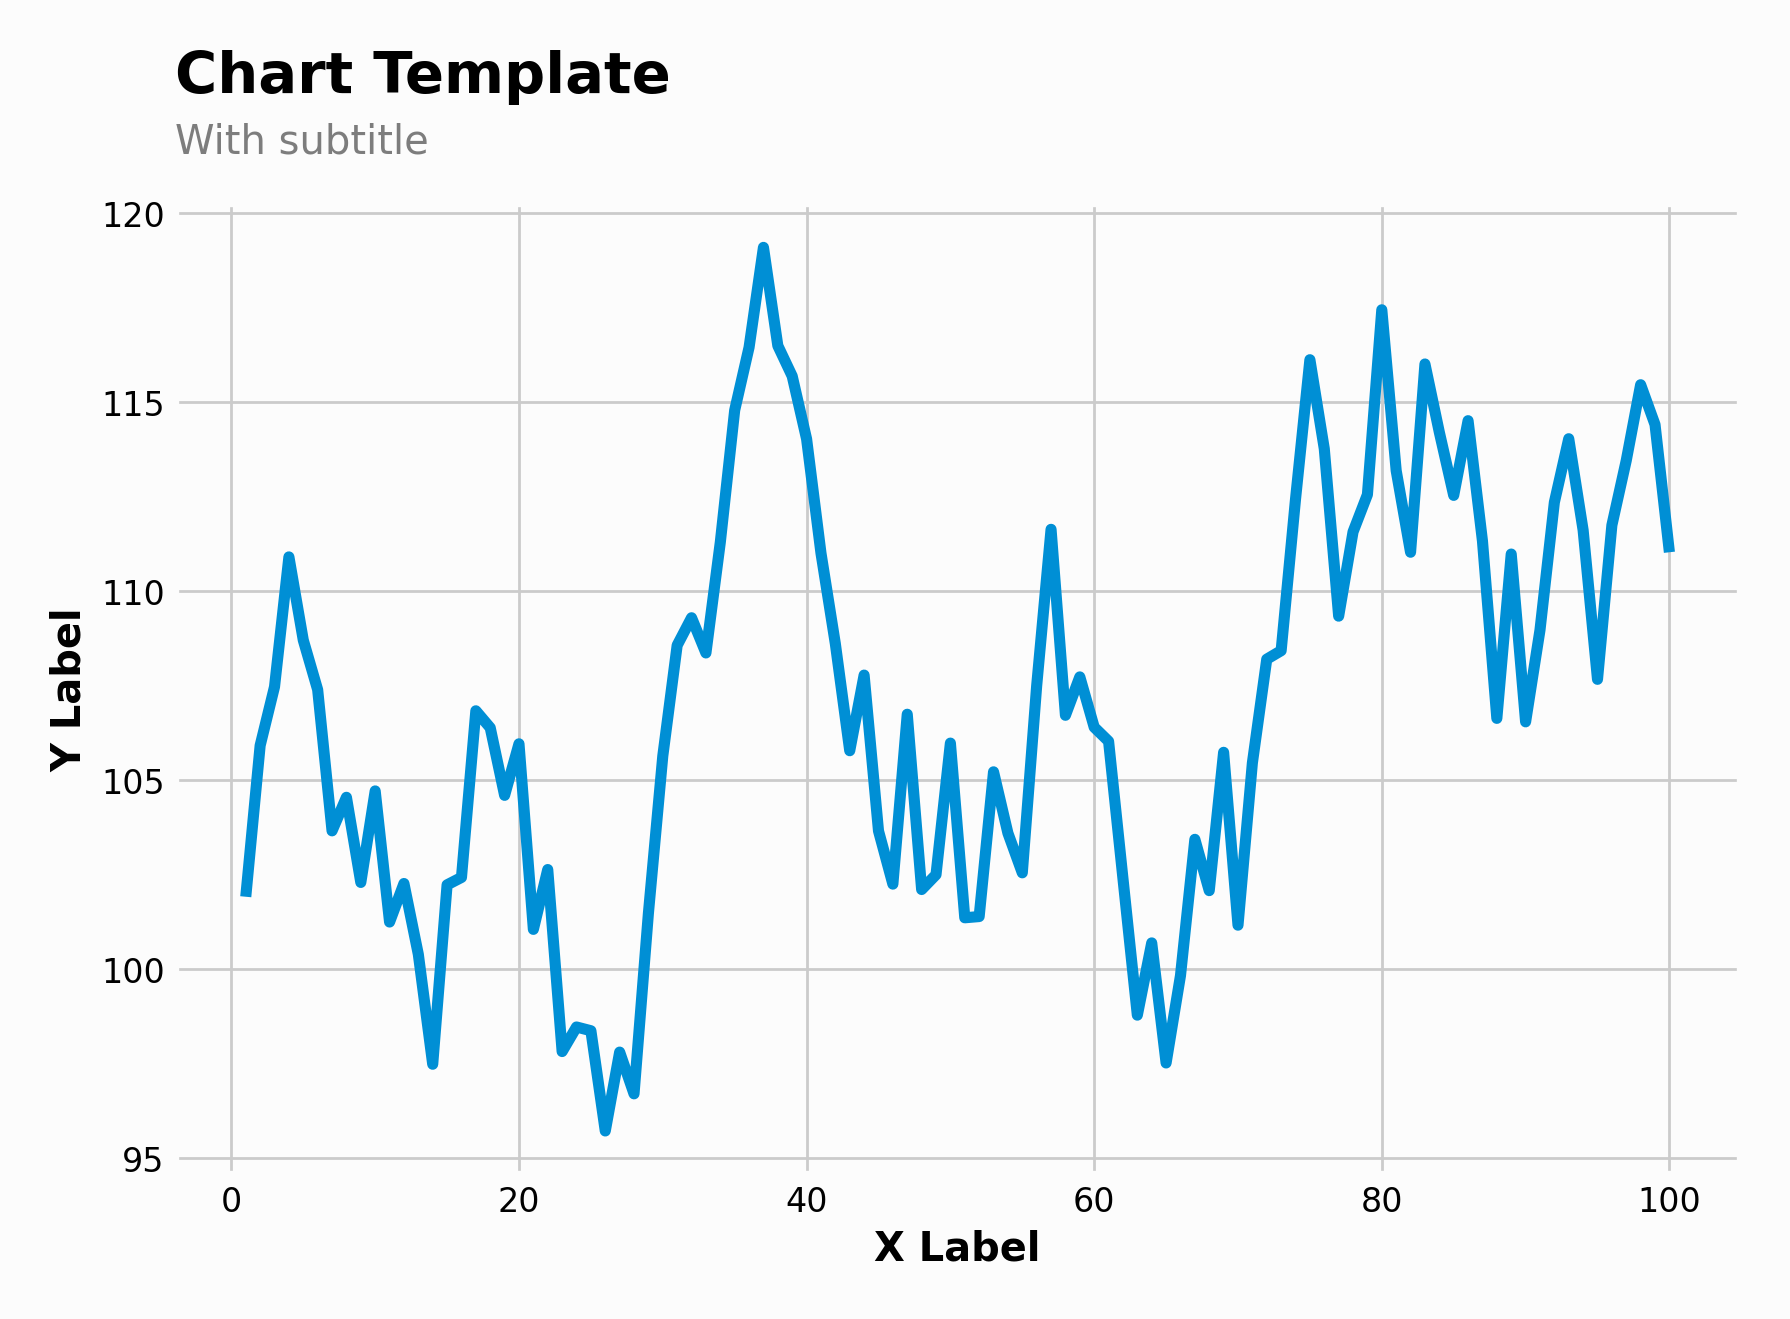

In [5]:
fig = plt.figure()
ax = plt.gca()

xs = range(1, 101)
ys = [random.random() * 10 - 5 for _ in xs]
ys = 100 + np.cumsum(ys)

ax = create_chart(
    'Chart Template', 'With subtitle',
    xlabel = 'X Label', ylabel = 'Y Label'
)
plt.plot(xs, ys);

In [6]:
# Global style setup
start_year, end_year = 1923, 2023
start_color, end_color = 'tab:orange', 'tab:blue'
plot_width = 9
plot_height = 6

min_line_color = 'gray'
max_line_color = 'gray'

minmax_line_style = '--'
minmax_line_width = 4

hline_style = { 'linestyle': ':', 'color': ('k', 0.4), 'linewidth': 2 }

year_annotation_style = { 'fontsize': 36, 'fontweight': 'bold' }

## Global Life Expectancies

Let's begin with an overview of how life expectancies have improved worldwide

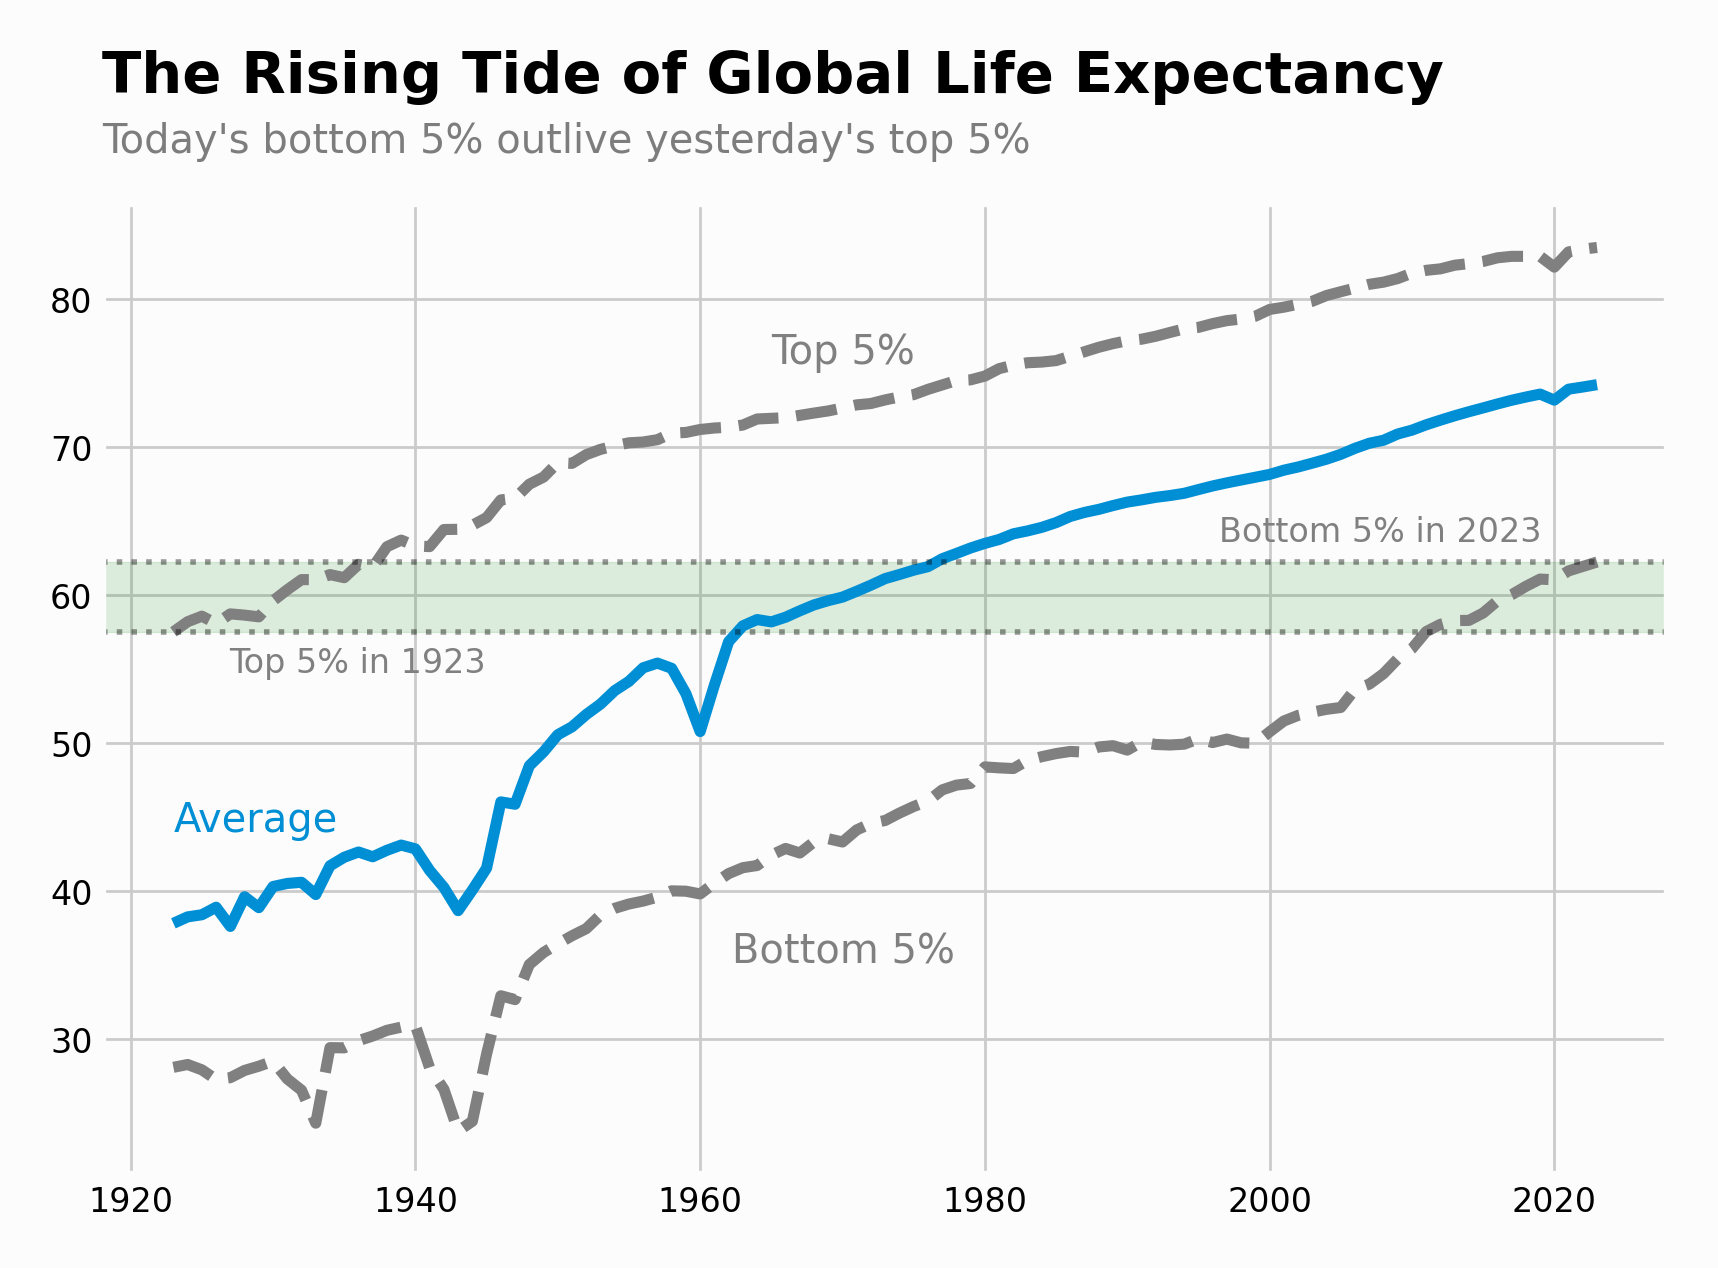

In [7]:
# Chart configuration
percentile = 5
chart_title = "The Rising Tide of Global Life Expectancy"
chart_subtitle = f"Today's bottom {percentile}% outlive yesterday's top {percentile}%"
line_color = 'C0'
highlight_color = ('green', 0.5)
highlight_linewidth = 5
highlight_arrowstyle = '->'
annotation_horizontal_offset = 20
annotation_vertical_offset = 5
annotation_fontsize = 'large'
highlight_area_style = { 'color': ('green', 1/8) }

def show_life_expectancy():
    ax = create_chart(chart_title, chart_subtitle)
    
    world_population = population.sum()
    weighted_life_expectancy = life_expectancy.copy()
    for column in weighted_life_expectancy.columns:
        weighted_life_expectancy[column] = weighted_life_expectancy[column] * population[column]
    # Average life expectancy per year, with each country weighted by its population.
    # This represents the average life expectancy of a random person in the world.
    weighted_average_life_expectancy = weighted_life_expectancy.sum() / world_population

    bottom = life_expectancy.quantile(percentile / 100)
    top = life_expectancy.quantile(1 - (percentile / 100))

    years = weighted_average_life_expectancy.index

    # Plot main lines
    plt.plot(years, weighted_average_life_expectancy, label="Average Life Expectancy", color=line_color)
    plt.plot(years, bottom, linestyle=minmax_line_style, linewidth=minmax_line_width, 
            color=min_line_color, label="Bottom 5%")
    plt.plot(years, top, linestyle=minmax_line_style, linewidth=minmax_line_width, 
            color=max_line_color, label="Top 5%")

    # Add horizontal lines for start and end points
    plt.axhline(top[start_year], **hline_style)
    plt.axhline(bottom[end_year], **hline_style)

    plt.axhspan(top[start_year], bottom[end_year], **highlight_area_style)

    # Add annotations for key points

    # Top 5% in start_year
    plt.annotate(
        f'Top {percentile}% in {start_year}', 
        xy=(start_year, top[start_year]), 
        va = 'top',
        xytext=(annotation_horizontal_offset, -annotation_vertical_offset), 
        textcoords='offset points',
        color=max_line_color
    )

    # Bottom 5% in end_year
    plt.annotate(
        f'Bottom {percentile}% in {end_year}', 
        xy=(end_year, bottom[end_year]), 
        ha = 'right', va = 'bottom',
        xytext=(-annotation_horizontal_offset, annotation_vertical_offset), 
        textcoords='offset points',
        color=min_line_color
    )

    # Arrow connecting top 5% in start_year to bottom 5% in end_year
    # plt.annotate(
    #     '',
    #     xy = (end_year, bottom[end_year]),
    #     xytext = (start_year, top[start_year]),
    #     arrowprops = { 
    #         'arrowstyle' : highlight_arrowstyle, 
    #         'color' : highlight_color,  
    #         'linewidth' : highlight_linewidth,
    #     },
    # )

    # Line labels to replace legend:

    # Top 5%
    mid_year = (start_year + end_year) / 2
    plt.annotate(
        f'Top {percentile}%',
        xy = (mid_year, top[mid_year]),
        xytext = (-15, 10), textcoords = 'offset points',
        ha = 'center', va = 'bottom',
        color = max_line_color,
        fontsize = annotation_fontsize
    )

    # Bottom 5%
    plt.annotate(
        f'Bottom {percentile}%',
        xy = (mid_year, bottom[mid_year]),
        xytext = (-15, -40), textcoords = 'offset points',
        ha = 'center', va = 'top',
        color = max_line_color,
        fontsize = annotation_fontsize
    )

    # Average life expectancy
    plt.annotate(
        f'Average',
        xy = (start_year, weighted_average_life_expectancy[start_year]),
        xytext = (0, 30), textcoords = 'offset points',
        ha = 'left', va = 'bottom',
        color = line_color,
        fontsize = annotation_fontsize
    )


show_life_expectancy()
plt.savefig('../charts/01-WorldLifeExpectancies.png')

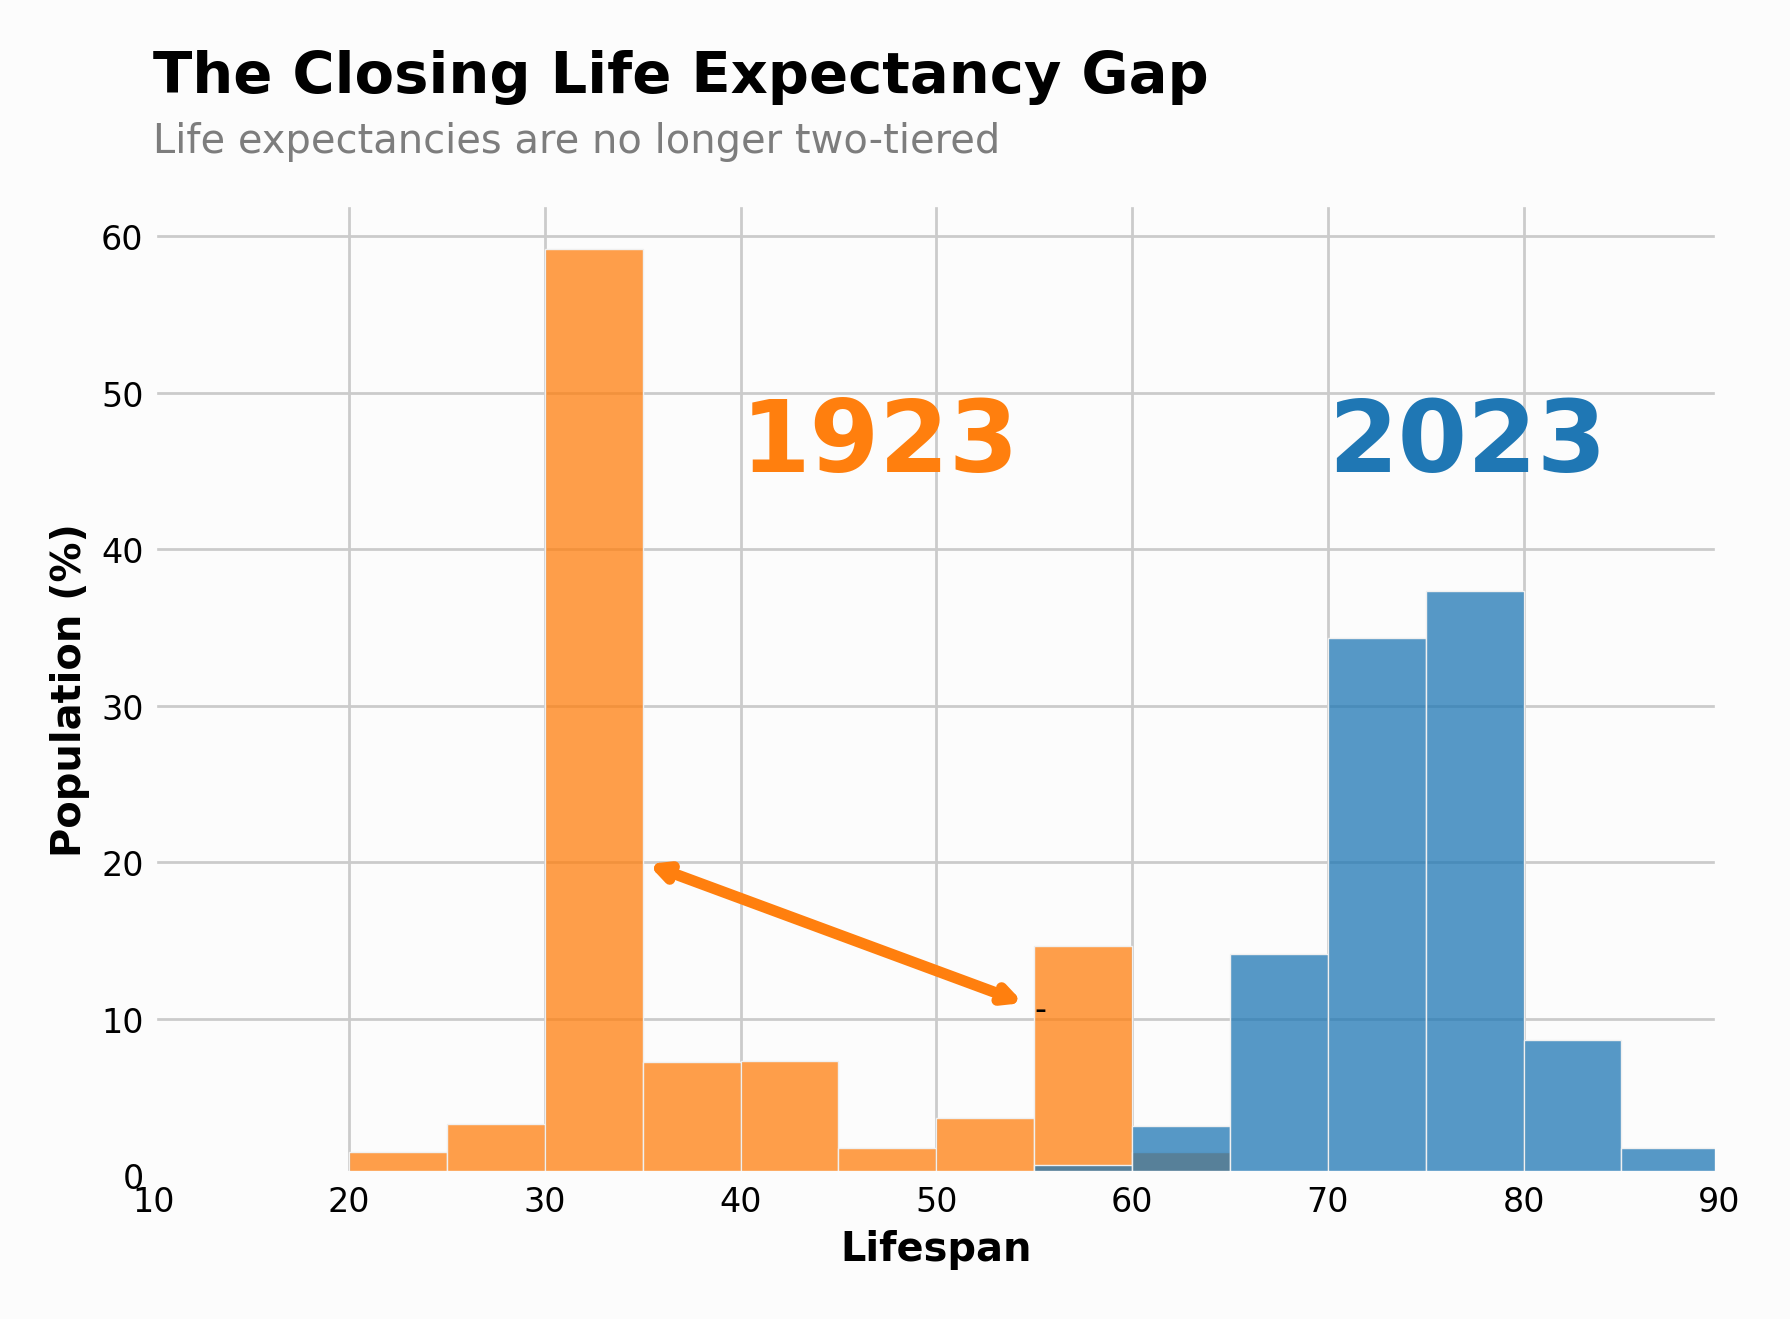

In [8]:
def life_expectancy_histogram(ages, populations, /, year, ymax = None):
    ax = plt.gca()
    sns.histplot(
        x = ages, 
        weights = populations, 
        binwidth = 5, binrange = (10, 90),
        color = start_color if year == start_year else end_color,
        stat = 'percent', 
        ax = ax
    )
    ax.set(
        xlabel = 'Lifespan', ylabel = 'Population (%)',
        xlim = (10, 90)
    )

create_chart(f"The Closing Life Expectancy Gap", 'Life expectancies are no longer two-tiered')
years = [start_year, end_year]
for year in years:
    ages = life_expectancy[year]
    populations = population[year]
    life_expectancy_histogram(ages, populations, year = year)

plt.text(40, 45, str(start_year), color = start_color, **year_annotation_style)
plt.text(70, 45, str(end_year), color = end_color, **year_annotation_style)
plt.annotate('-', xy = (35, 20), xytext = (55, 10), arrowprops = {'arrowstyle': '<->', 'color': start_color, 'linewidth': 4});

plt.savefig('../charts/02-LifeExpectancyGap.png')

TRENDLINE: Lifespan(1923) ~ 12.97 * log(GNI) - 0.08
TRENDLINE: Lifespan(2023) ~ 9.10 * log(GNI) + 39.41


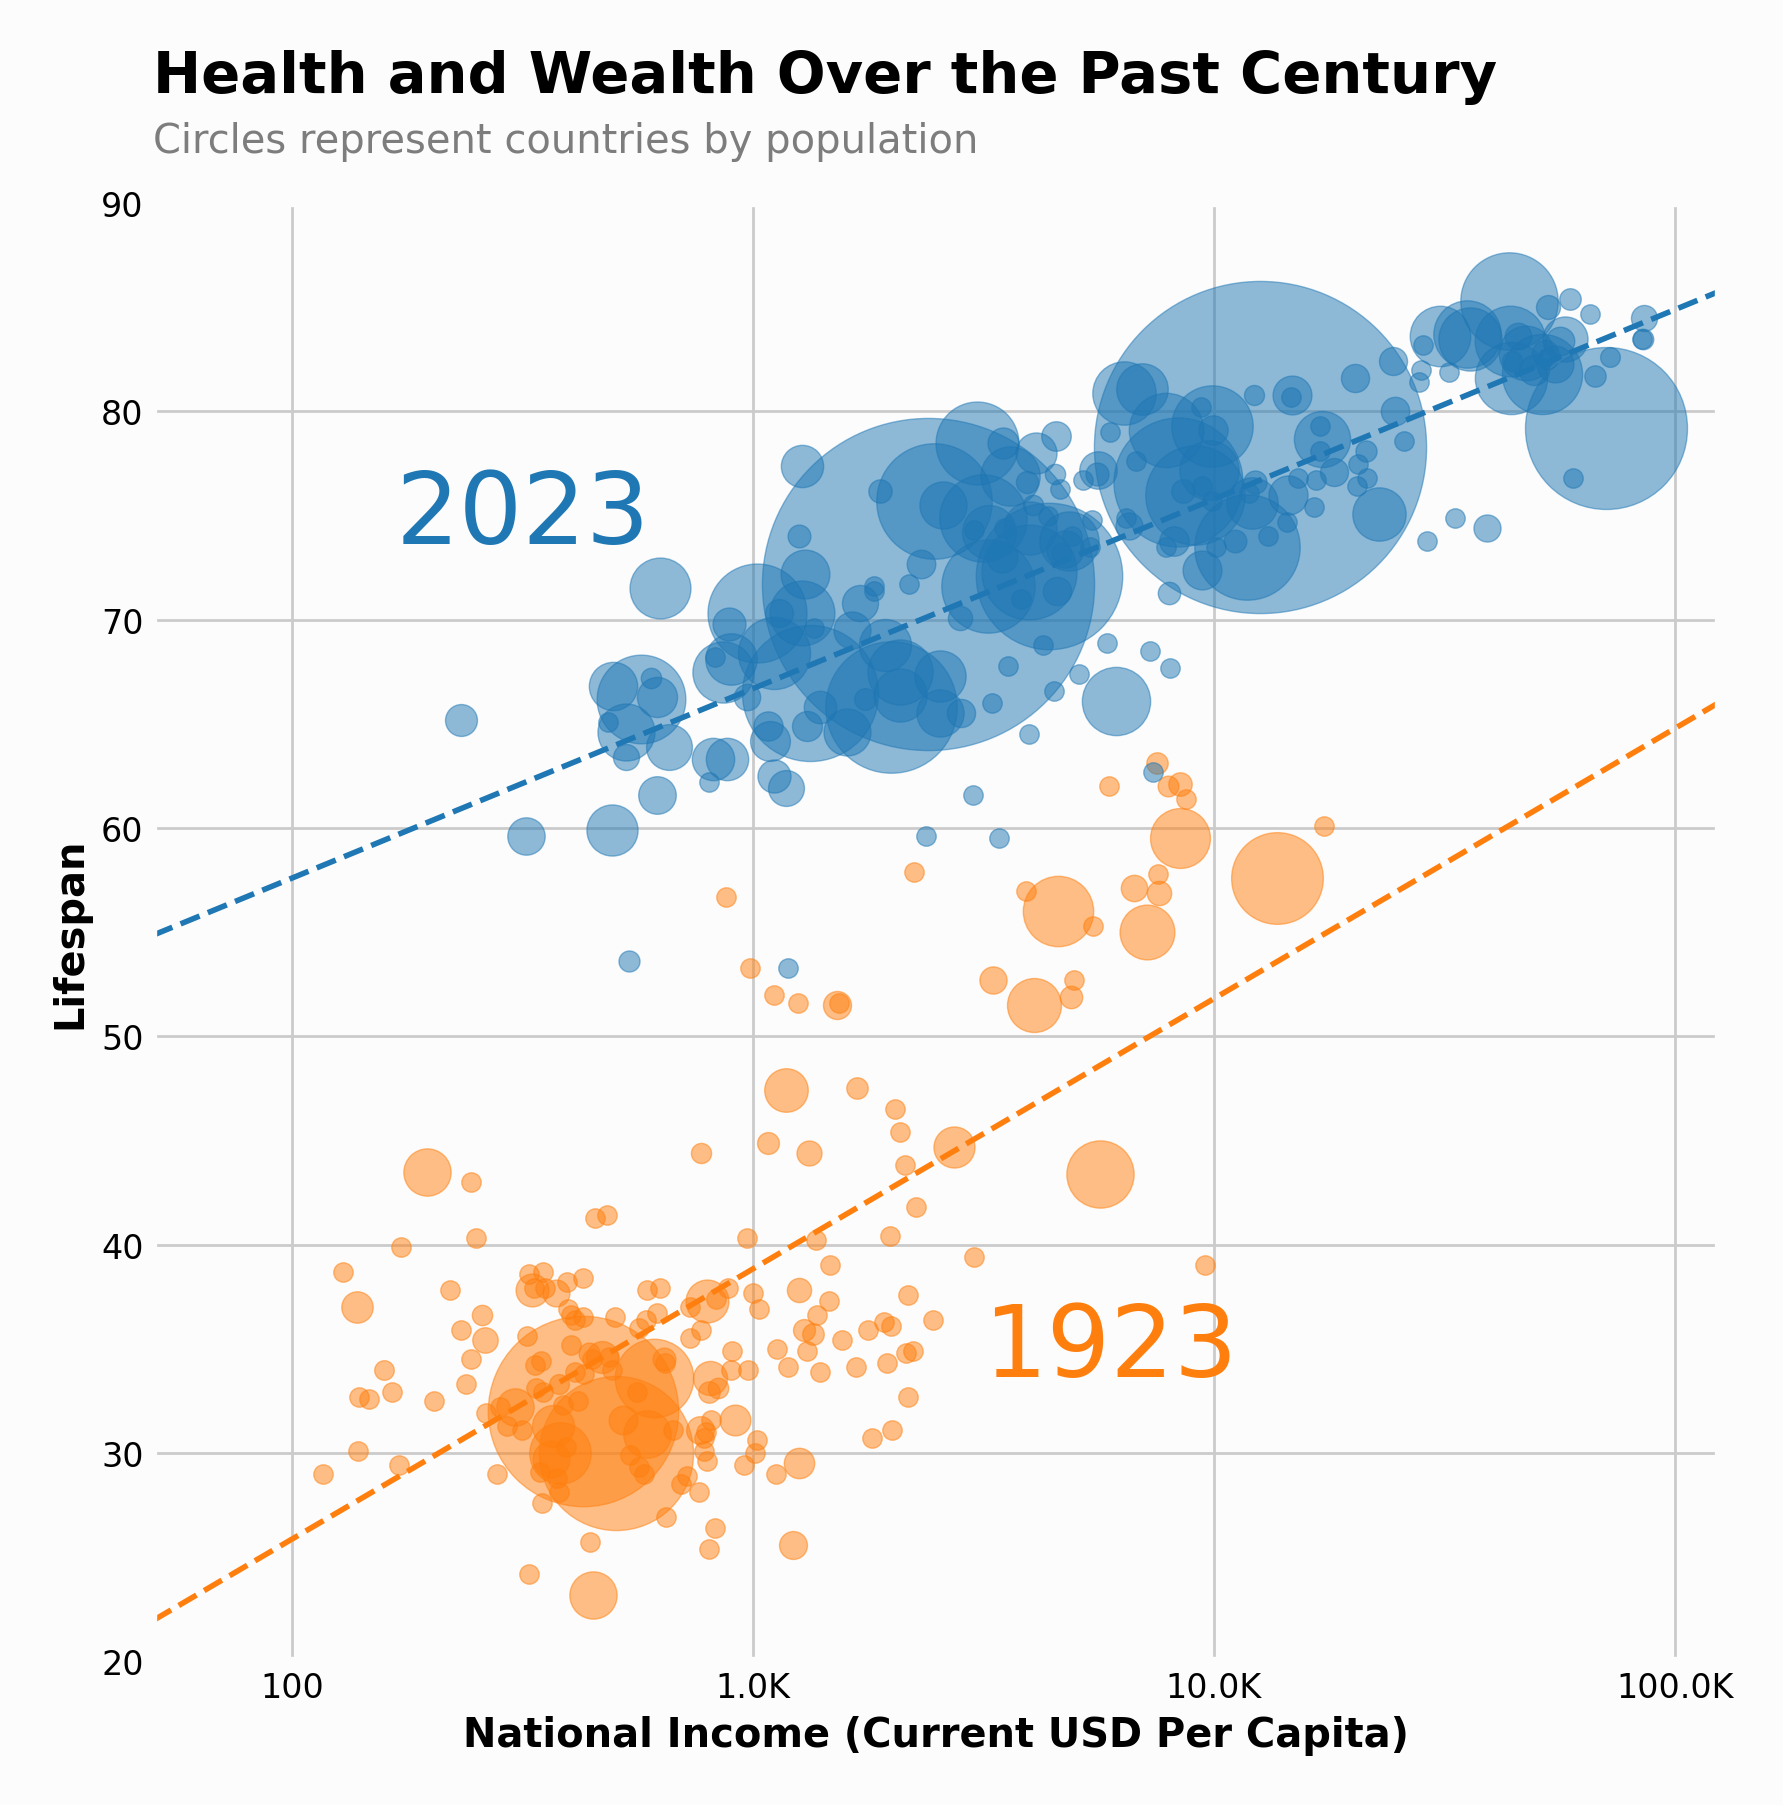

In [9]:
# Scatterplot: Income vs Life Expectancy - 1923 vs 2023
scatter_alpha = 0.5
life_expectancy_min = 20
life_expectancy_max = 90
trendline_width = 2
trendline_style = '--'
points_per_inch = 72

def describe_int(value) -> str:
    # Given a numeric value, output the number in a way intended for large integers, using K/M/B suffices for thousands/millions/billions.
    # E.g.: 1_234_567.0 -> '1.2M'
    if type(value) == str:
        return value
    if value >= 1_000_000_000:
        return f'{value / 1_000_000_000:,.1f}B'
    if value >= 1_000_000:
        return f'{value / 1_000_000:,.1f}M'
    if value >= 1_000:
        return f'{value / 1_000:,.1f}K'
    return f'{int(value):,}'

def describe_float(value) -> str:
    # Outputs fractional numbers in abbreviated format for display, limiting their number of trailing decimals.
    if type(value) == str:
        return value
    return f'{float(value):,.2f}'

def dot_size(population):
    min_r = 7
    result = population / 100_000
    return max(result, min_r ** 2)

def gni_scatterplot(year):
    plt.xlabel('National Income (Current USD Per Capita)')
    plt.ylabel('Lifespan')
    ticks = [100, 1_000, 10_000, 100_000]
    plt.xticks(ticks = list(map(np.log10, ticks)), labels = list(map(describe_int, ticks)))
    plt.xlim(left = np.log10(50), right = np.log10(125_000))
    plt.ylim(bottom = life_expectancy_min, top = life_expectancy_max)
    gnis = gni[year].map(np.log10)
    les = life_expectancy[year]
    pops = population[year]
    for country in gnis.index:
        pop = pops.loc[country]
        plt.scatter([gnis.loc[country]], [les.loc[country]], s = dot_size(pop), alpha = scatter_alpha, color = start_color if year == start_year else end_color, label = year)
    return plt.gca()

plt.figure(figsize = (9,9))
create_chart(
    'Health and Wealth Over the Past Century',
    'Circles represent countries by population',
    xlabel = 'National Income (Current USD Per Capita)',
    ylabel = 'Life Expectancy'
)
gni_scatterplot(start_year)
gni_scatterplot(end_year)
plt.annotate(text = f'{start_year}',  xy = (3.5, 35), verticalalignment = 'center', color = start_color, fontsize = 36)
plt.annotate(text = f'{end_year}',  xy = (2.5, 75), horizontalalignment = 'center', verticalalignment = 'center', color = end_color, fontsize = 36);

def line_data(slope: float, intercept: float) -> tuple:
    # Given a slope + intercept, return data that will produce a line across the entire current graph.
    # E.g:
    # x, y = line_data(intercept = 1, slope = 1.5)
    # plt.plot(x, y)
    ax = plt.gca()
    xmin, xmax = ax.get_xlim()
    ymin = slope * xmin + intercept
    ymax = slope * xmax + intercept
    # verified that matplotlib automatically crops out-of-bounds y values, so no further processing is needed.
    return ([xmin, xmax], [ymin, ymax])

# Add trendlines showing correlation
lr = LinearRegression()
data = pd.DataFrame()
for year in [start_year, end_year]:
    data = gni[[year]].map(np.log10).rename({year:"GNI"}, axis = 1)
    data["LE"] = life_expectancy[year]
    # matplotlib/pandas can handle null values, but scikitlearn cannot. Let's remove all rows containing null values.
    data = data.dropna()
    lr.fit(data[["GNI"]], data["LE"])
    # trendline: Lifespan = a * log(gni) + b, with log(gni) = x axis
    # let's call a = intercept, b = slope
    # to do: is there a better way? The rendering portion of this task seems awfully tedious.
    # the problem with rendering lr.predict(GNI) - a simple approach - is that the trend line's range would be restricted. But we want to span the entire graph instead.
    intercept = lr.intercept_
    slope = lr.coef_[0]
    print(f'TRENDLINE: Lifespan({year}) ~ {slope:.2f} * log(GNI) {'-' if intercept < 0 else '+'} {abs(intercept):.2f}')
    x, y = line_data(intercept = intercept, slope = slope)
    plt.plot(x, y, color = start_color if year == start_year else end_color, linestyle = trendline_style, linewidth = trendline_width)


plt.savefig('../charts/03-HealthAndWealth.png')


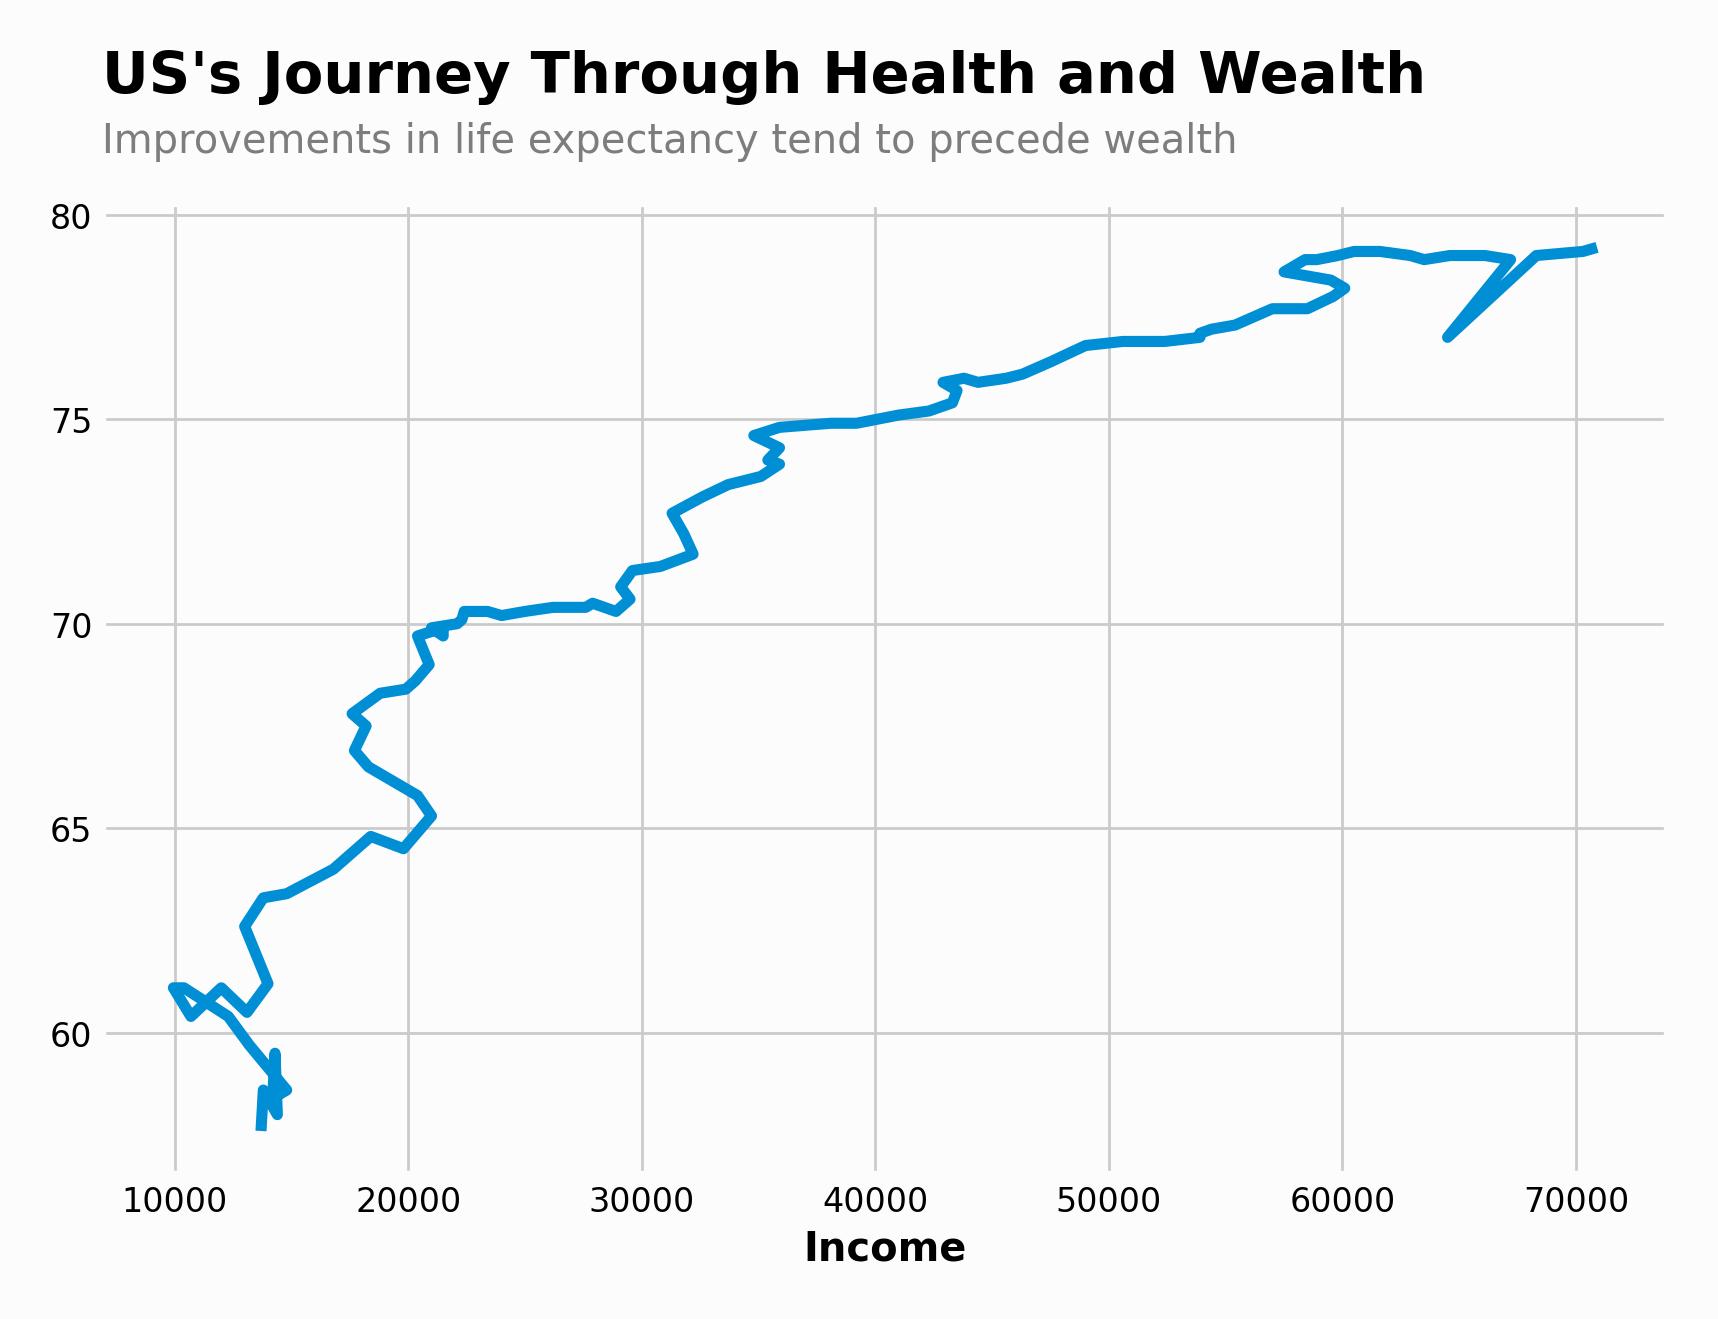

In [10]:
# And now for something a little bit different:
#
# An unusual visualization showing how US has improved both its health and its wealth over time.
# This visualization breaks down when using multiple countries or a country with a varied history, but works 
# well for the US. An intresting aspect of the visualization is paying attention to changes in direction in 
# the path toward progress. For example, 2021 (COVID) is the only point in history where US is moving backwards 
# on both dimensions.
create_chart('US\'s Journey Through Health and Wealth', 'Improvements in life expectancy tend to precede wealth')
countries = ['United States']
for country in countries:
    gnis = gni.loc[country]
    life_expectancies = life_expectancy.loc[country]
    plt.plot(gnis, life_expectancies)
    plt.xlabel("Income")

plt.savefig('../charts/04-USIncomeVsLifeExpectancy.png')

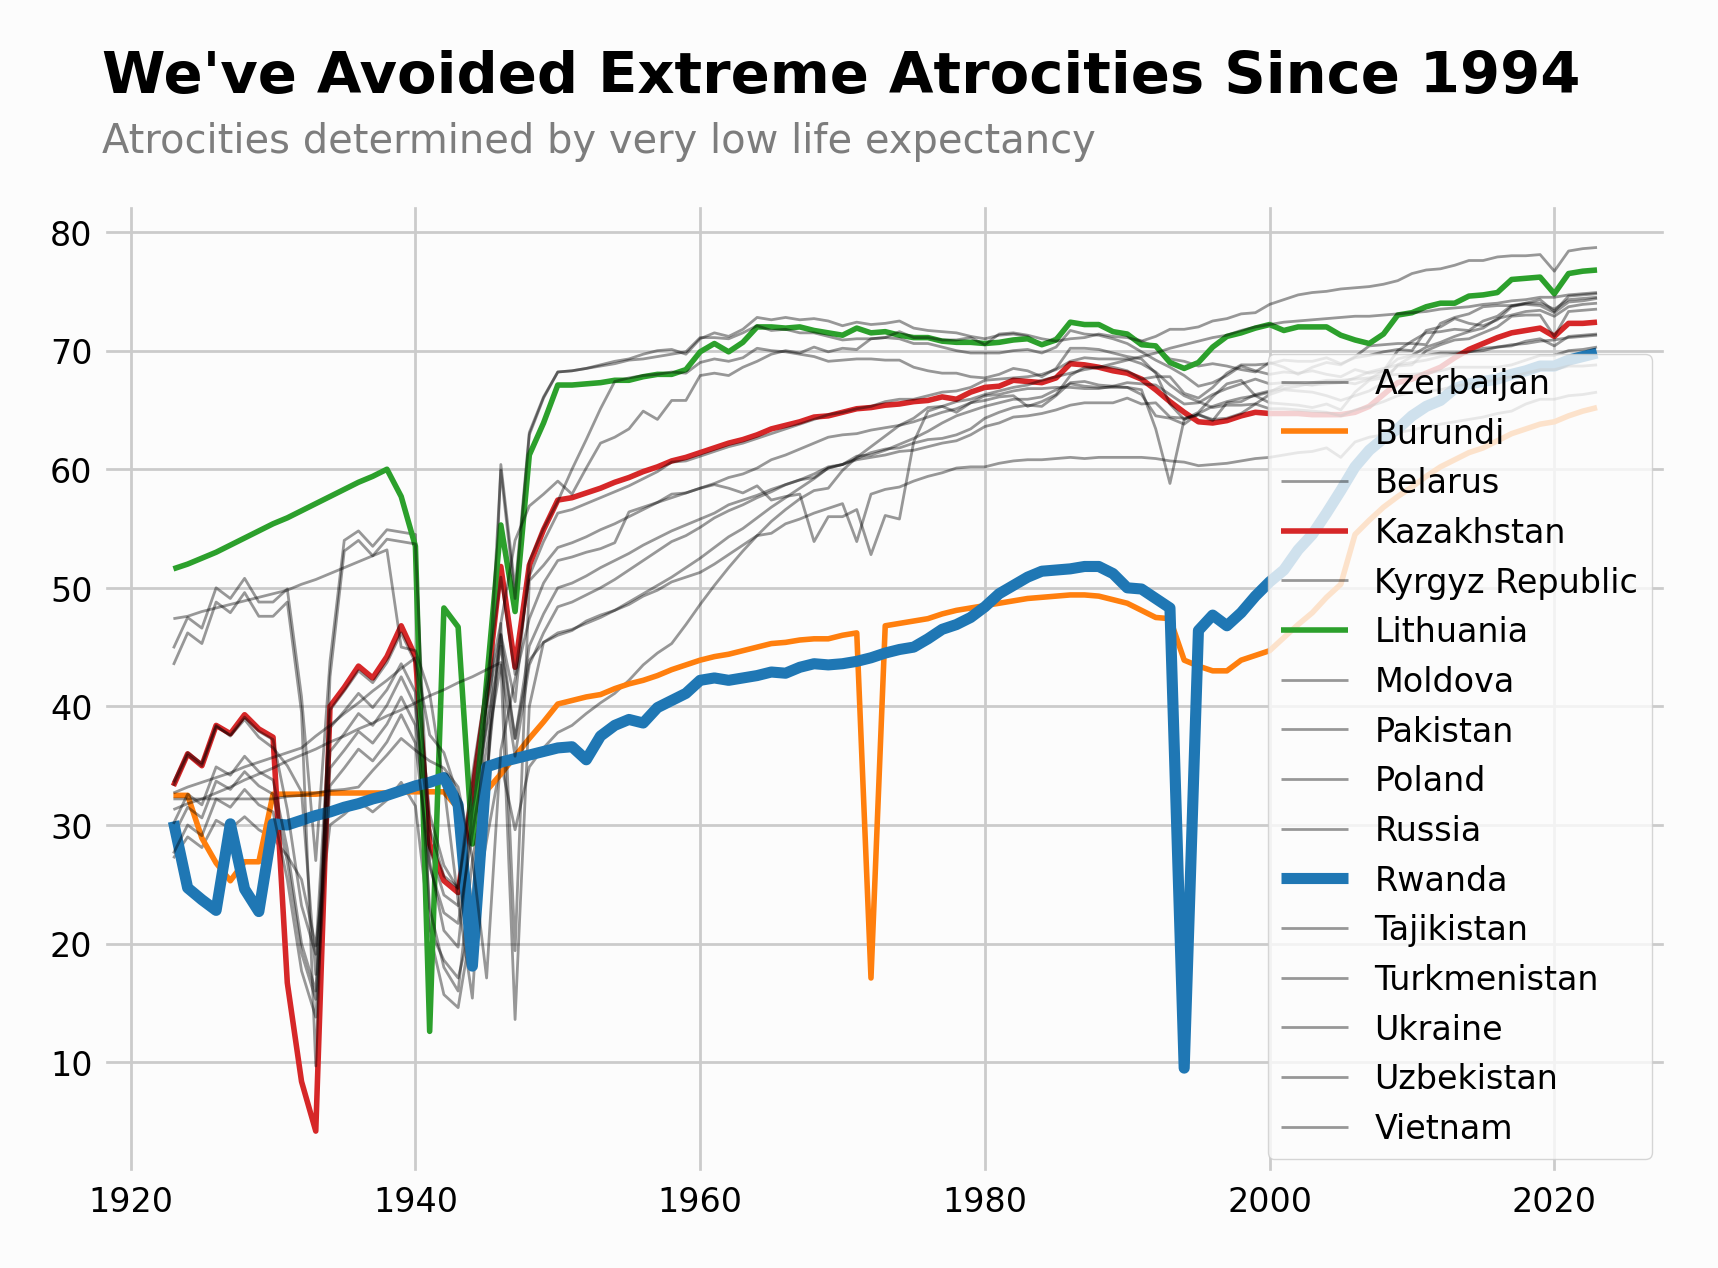

In [11]:
minor_country_alpha = 0.4

rock_bottom = life_expectancy.loc[life_expectancy.min(axis = 1) < 20]
create_chart("We've Avoided Extreme Atrocities Since 1994", "Atrocities determined by very low life expectancy")
# This plot gets quite noisy. Highlight the important parts:
# Rwanda = last outsized incident (genocide)
# Burundi = last large incident prior to Rwanda + related to Rwanda
# Kazakhstan = lowest recorded life expectancy ever
# Lithuania = most impacted life expectancy from WW2 (why?)
color_map = {
    'Rwanda': 'tab:blue',
    'Burundi': 'tab:orange',
    'Lithuania': 'tab:green',
    'Kazakhstan': 'tab:red',
    'other': 'black'
}
for country in rock_bottom.index:
    life_expectancies = rock_bottom.loc[country]
    color = color_map.get(country)
    if color != None:
        plt.plot(life_expectancies, linewidth = 4 if country == 'Rwanda' else 2, color = color)
    else:
        plt.plot(life_expectancies, linewidth = 1, color = color_map['other'], alpha = minor_country_alpha)
plt.legend(rock_bottom.index)

plt.savefig('../charts/05-Atrocities.png')
